# Import libraries

In [1]:
import numpy as np 
import pandas as pd 

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

import PIL
import requests
from io import BytesIO 

# Download the Dataset

In [2]:
#This dataset is already included in TensorFlow Datasets and we can simply download it.

!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0
# download the dataset and get info
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

W1214 11:26:31.518674 139927737173888 download_and_prepare.py:42] ***`tfds build` should be used instead of `download_and_prepare`.***
INFO[build.py]: Loading dataset oxford_iiit_pet:3.1.0 from imports: tensorflow_datasets.image_classification.oxford_iiit_pet
Traceback (most recent call last):
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.8/dist-packages/tensorflow_datasets/scripts/download_and_prepare.py", line 52, in <module>
    app.run(main, flags_parser=_parse_flags)
  File "/usr/local/lib/python3.8/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.8/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.8/dist-packages/tensorflow_datasets/scripts/download_and_prepare.py", line 48, in main
 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteMYENUV/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteMYENUV/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
print(dataset.keys())

dict_keys(['train', 'test'])


# Preprocessing the dataset

In [4]:
def random_flip(input_image, input_mask):
    '''does a random flip of the image and mask'''
    if tf.random.uniform(()) > 0.5:
        # we wand to randomly flip images if a random genarated value 
        # is bigger than 0.5 we will flip the image, else leave it 
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask


def normalize(input_image, input_mask):
    '''
    normalizes the input image pixel values to be from [0,1].
    subtracts 1 from the mask labels to have a range from [0,2]
    '''
    # Normalize the input image by casting to float32 and the divide 
    # each pixel value in the input imageby 255 
    input_image = tf.cast(input_image, tf.float32) / 255.0
    
    # adjust the segmentation mask's pixel values.
    # in the original dataset the pixels in the segmentation mask are labeled as such:
    # 1:foreground, 2:background, 3:Not Classified
    # subtract 1 from these values and we will interpret these as {'pet', 'background', 'outline'}
    input_mask -= 1
    return input_image, input_mask

# The data is already splitted to training and testing datasets

@tf.function
def load_image_train(datapoint):
    '''resizes, normalizes, and flips the training data'''
    
    # resize the input image to 128 x 128
    input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
    
    # resize the mask to 128 x 128
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
    
    # Augmentation and normalization using the previosly defined fumctions
    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


def load_image_test(datapoint):
    '''resizes and normalizes the test data'''
    
    # preparing the test images without Augmentation 
    input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [5]:
# preprocess the train and test sets
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [6]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000

# shuffle and group the train set into batches
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# do a prefetch to optimize processing
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# group the test set into batches
test_dataset = test.batch(BATCH_SIZE)

## Some utilities to help us visualize our data and metrics.

In [7]:
# class list of the mask pixels
class_names = ['pet', 'background', 'outline']


def display_with_metrics(display_list, iou_list, dice_score_list):
    '''displays a list of images/masks and overlays a list of IOU and Dice Scores'''
  
    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
    metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
    display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
    display_string = "\n\n".join(display_string_list)

    display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string) 


def display(display_list,titles=[], display_string=None):
    '''displays a list of images/masks'''

    plt.figure(figsize=(15, 15))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        if display_string and i == 1:
            plt.xlabel(display_string, fontsize=12)
        img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
        plt.imshow(img_arr)
  
    plt.show()


def show_image_from_dataset(dataset):
    '''displays the first image and its mask from a dataset'''

    for image, mask in dataset.take(1):
        sample_image, sample_mask = image, mask
    display([sample_image, sample_mask], titles=["Image", "True Mask"])


def plot_metrics(metric_name, title, ylim=5):
    '''plots a given metric from the model history'''
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
    plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

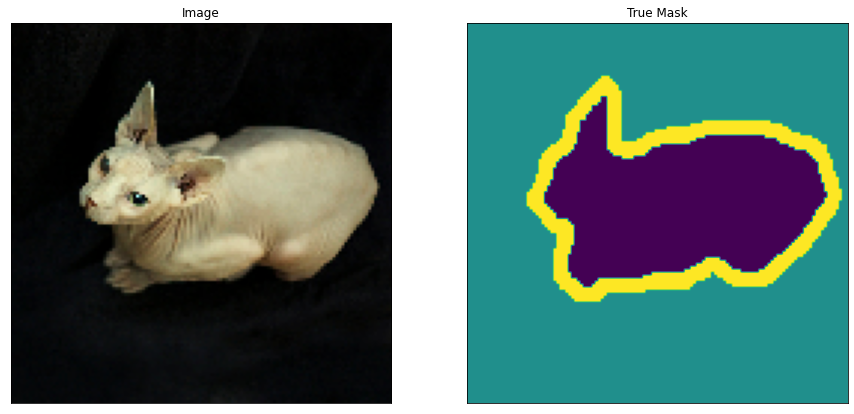

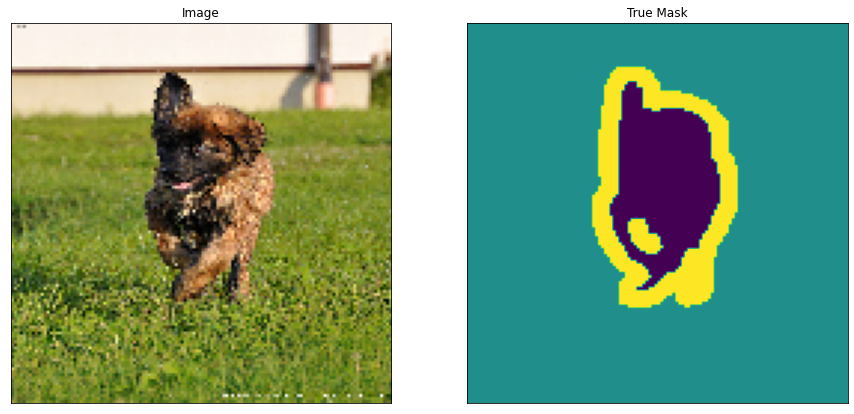

In [8]:
# display an image from the train set
show_image_from_dataset(train)

# display an image from the test set
show_image_from_dataset(test)

# Build the Model

In [9]:
from IPython.display import Image
Image(url= "https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png")

## Encoder

In [10]:
# Encoder Utilities

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    '''
    Adds 2 convolutional layers with the parameters passed to it

    Args:
      input_tensor (tensor) -- the input tensor
      n_filters (int) -- number of filters
      kernel_size (int) -- kernel size for the convolution

    Returns:
      tensor of output features
    '''
    # first layer
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
                                   kernel_initializer = 'he_normal', padding = 'same')(x)
        x = tf.keras.layers.Activation('relu')(x)
  
    return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
    '''
    Adds two convolutional blocks and then perform down sampling on output of convolutions.

    Args:
      input_tensor (tensor) -- the input tensor
      n_filters (int) -- number of filters
      kernel_size (int) -- kernel size for the convolution

    Returns:
      f - the output features of the convolution block 
      p - the maxpooled features with dropout
    '''

    f = conv2d_block(inputs, n_filters=n_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
    p = tf.keras.layers.Dropout(0.3)(p)

    return f, p


def encoder(inputs):
    '''
    This function defines the encoder or downsampling path.

    Args:
      inputs (tensor) -- batch of input images

    Returns:
      p4 - the output maxpooled features of the last encoder block
      (f1, f2, f3, f4) - the output features of all the encoder blocks
    '''
    f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
    f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
    f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
    f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

    return p4, (f1, f2, f3, f4)

## Bottleneck

In [11]:
def bottleneck(inputs):
    '''
    This function defines the bottleneck convolutions to extract more features before the upsampling layers.
    '''
  
    bottle_neck = conv2d_block(inputs, n_filters=1024)

    return bottle_neck

## Decoder

In [12]:
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
    '''
    defines the one decoder block of the UNet

    Args:
      inputs (tensor) -- batch of input features
      conv_output (tensor) -- features from an encoder block
      n_filters (int) -- number of filters
      kernel_size (int) -- kernel size
      strides (int) -- strides for the deconvolution/upsampling
      padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

    Returns:
      c (tensor) -- output features of the decoder block
   '''
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters, kernel_size=3)

    return c


def decoder(inputs, convs, output_channels):
    '''
    Defines the decoder of the UNet chaining together 4 decoder blocks. 
  
    Args:
      inputs (tensor) -- batch of input features
      convs (tuple) -- features from the encoder blocks
      output_channels (int) -- number of classes in the label map

    Returns:
      outputs (tensor) -- the pixel wise label map of the image
    '''
  
    f1, f2, f3, f4 = convs

    c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

    outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

    return outputs

## All Together

In [13]:
OUTPUT_CHANNELS = 3

def unet():
    '''
    Defines the UNet by connecting the encoder, bottleneck and decoder.
    '''

    # specify the input shape
    inputs = tf.keras.layers.Input(shape=(128, 128,3,))

    # feed the inputs to the encoder
    encoder_output, convs = encoder(inputs)

    # feed the encoder output to the bottleneck
    bottle_neck = bottleneck(encoder_output)

    # feed the bottleneck and encoder block outputs to the decoder
    # specify the number of classes via the `output_channels` argument
    outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)
  
    # create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# instantiate the model
model = unet()

# see the resulting model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

## Compile and Train the model

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:

TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 20
VAL_SUBSPLITS = 15
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/20
230/230 [==============================] - 74s 247ms/step - loss: 0.7503 - accuracy: 0.6769 - val_loss: 0.6261 - val_accuracy: 0.7465
Epoch 2/20
230/230 [==============================] - 56s 245ms/step - loss: 0.5703 - accuracy: 0.7731 - val_loss: 0.5336 - val_accuracy: 0.7886
Epoch 3/20
230/230 [==============================] - 56s 245ms/step - loss: 0.4996 - accuracy: 0.8051 - val_loss: 0.4442 - val_accuracy: 0.8250
Epoch 4/20
230/230 [==============================] - 56s 245ms/step - loss: 0.4592 - accuracy: 0.8234 - val_loss: 0.4283 - val_accuracy: 0.8398
Epoch 5/20
230/230 [==============================] - 56s 245ms/step - loss: 0.4288 - accuracy: 0.8358 - val_loss: 0.4084 - val_accuracy: 0.8421
Epoch 6/20
230/230 [==============================] - 56s 245ms/step - loss: 0.4172 - accuracy: 0.8407 - val_loss: 0.3800 - val_accuracy: 0.8545
Epoch 7/20
230/230 [==============================] - 56s 245ms/step - loss: 0.3878 - accuracy: 0.8515 - val_loss: 0.4935 - val_ac

In [15]:
# Plot the training and validation loss
plot_metrics("loss", title="Training vs Validation Loss", ylim=1)

## Predictions

In [16]:
def get_test_image_and_annotation_arrays():
    '''
      Unpacks the test dataset and returns the input images and segmentation masks
  '''

    ds = test_dataset.unbatch()
    ds = ds.batch(info.splits['test'].num_examples)
  
    images = []
    y_true_segments = []

    for image, annotation in ds.take(1):
        y_true_segments = annotation.numpy()
        images = image.numpy()
  
    y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
  
    return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments


def create_mask(pred_mask):
    '''
    Creates the segmentation mask by getting the channel with the highest probability. Remember that we
    have 3 channels in the output of the UNet. For each pixel, the predicition will be the channel with the
    highest probability.
    '''
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0].numpy()


def make_predictions(image, num=1):
    '''
    Feeds an image to a model and returns the predicted mask.
    '''

    image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)

    return pred_mask

In [18]:
def class_wise_metrics(y_true, y_pred):
    class_wise_iou = []
    class_wise_dice_score = []

    smoothening_factor = 0.00001
    for i in range(3):
    
        intersection = np.sum((y_pred == i) * (y_true == i))
        y_true_area = np.sum((y_true == i))
        y_pred_area = np.sum((y_pred == i))
        combined_area = y_true_area + y_pred_area

        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)

        dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        class_wise_dice_score.append(dice_score)

    return class_wise_iou, class_wise_dice_score

In [19]:
# Setup the ground truth and predictions.

# get the ground truth from the test set
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

# feed the test set to th emodel to get the predicted masks
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]

229/229 [==============================] - 18s 76ms/step


In [20]:
# compute the class wise metrics
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

In [21]:
# show the IOU for each class
for idx, iou in enumerate(cls_wise_iou):
    spaces = ' ' * (10-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, iou))

pet         0.781473047251989 
background  0.879510216016384 
outline     0.4521496364501422 


In [22]:
# show the Dice Score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
    spaces = ' ' * (10-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, dice_score))

pet         0.8773335621974829 
background  0.9358929879941057 
outline     0.6227314666494037 


## Make a prediction on an image from the web¶


In [17]:
def Make_a_prediction_on_an_image_from_the_web(url):
    
    response = requests.get(url)
    img = PIL.Image.open(BytesIO(response.content))
    img = img.resize((128, 128))
    img_array = np.array(img)
    pred = make_predictions(img_array,  num=1)
    display([img, pred],titles=['Image', 'Prediction'], display_string=None)

1/1 [==============================] - 0s 19ms/step


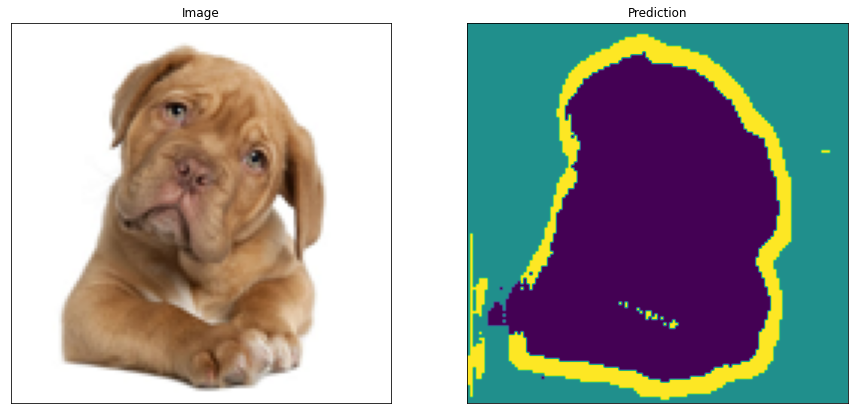

In [26]:
img_2 = "https://www.dbrg.uk/uploads/5/5/5/6/55561953/published/gui de-buying-puppy.jpg?1513968022"
Make_a_prediction_on_an_image_from_the_web(img_2)

1/1 [==============================] - 0s 25ms/step


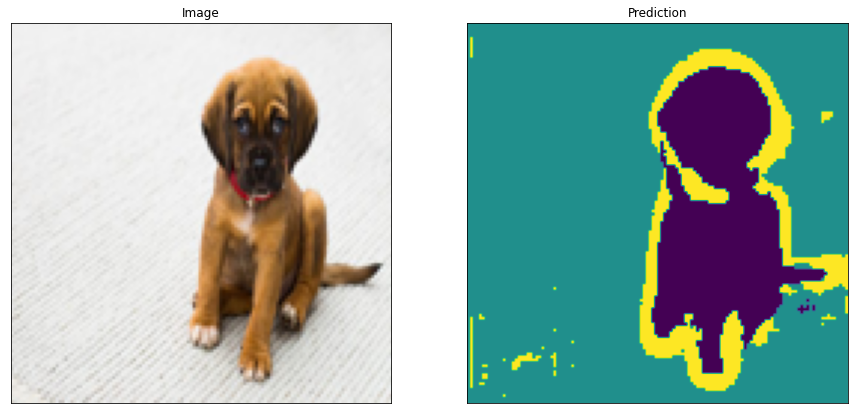

In [27]:
img_3 = "https://www.oliverpetcare.com/wp-content/uploads/2019/11/puppy-dog-animal-pet-mammal-pug-1046756-pxhere.com_-e1572947696385.jpg"
Make_a_prediction_on_an_image_from_the_web(img_3)